In [1]:
# from model_phantom_DB import *
# from linares_plot import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Style of poster for the plots
sns.set_context("poster", font_scale=1.1) ## poster format
sns.set_style("ticks")


For all the matrice data : each row is one trial, each column is one neuron. 
For the same row the trial data may not be collected on the same trial since data might are collected on different days.

cuerate: firing rate during 1st visual stimuli(cue) presentation.

cuerate_stim: firing rate during 1st cue presentation with NB stimulation. 

cdrate: firing rate during the 1st delay after 1st cue presentation. 

cdrate_stim: firing rate during the 1st delay after cue presentation  with NB stimulation.  
 
samplerate: firing rate during 2nd visual stimuli(sample) presentation. 

samplerate_stim: firing rate during sample presentation with NB stimulation. 

sdrate: firing rate during the delay after sample presentation. 

sdrate_stim: firing rate during the delay after sample presentation with NB stimulation. 

g1: location of 1st visual stimuli(cue)
 value -1 means no visual stimuli presented.
 value [1 2 3 4 5] are  relative locaions, such as [0 45 90 135 180], or [ 45 90 135 180 225], etc.
 The real locations depended on neurons' receptive field.
 According to our behavioral paradigm, the cue will only be presented on locaion [1 5]. that is two opposite locations, such as [0 180], [45 225], etc.
 For each neuron, thoes value([1:5]) refer to the same locations.

g2: location of 2nd visual stimuli(sample)
  Sample can show up in all five possible locations([1:5]) or not presented(-1).

g3: task type for each trial, eg. saccade to 1st (value 1), or saccade to 2nd(value 2).


In [2]:
from scipy.io import loadmat 
file = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Classifiy_data_odrdistvar_allNeurons_reverse.matlab'
data = loadmat(file)
data.keys()

dict_keys(['g2', 'g3', '__globals__', 'cuerate_stim', '__version__', 'g1_stim', 'cuerate', 'cdrate_stim', 'cdrate', 'samplerate', 'g2_stim', 'g3_stim', 'g1', 'sdrate', 'samplerate_stim', '__header__', 'sdrate_stim'])

In [3]:
rate_d1_off = data['cdrate']
positions_stim_off= data['g1'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

rate_d1_on = data['cdrate_stim']
positions_stim_on= data['g1_stim'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

number_neurons = np.shape(rate_d1_on)[1]

### OFF

In [29]:
number_neurons = np.shape(rate_d1_off)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='OFF'
reps_ = 50# 1000 ### I have done the graph with 1000 reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### append the cross-validated outcome (cross validated measure extracted from this)
fpr_mean_off_all = []
tpr_mean_off_all = []
roc_mean_off_all = []


for Neuron in range(number_neurons):
    print(Neuron)
    fpr_mean_off = []
    tpr_mean_off = []
    roc_mean_off = []
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_off.append(fpr["macro"])
        tpr_mean_off.append(tpr["macro"])
        roc_mean_off.append(roc_auc["macro"])
    ###
    ###
    ### ## save the cross validate mean value for each neuron
    df_mean = pd.DataFrame({'fpr': np.concatenate(fpr_mean_off), 'tpr': np.concatenate(tpr_mean_off)})
    df_mean = df_mean.round(2)
    fpr_n=[]
    for unique_tpr in df_mean.tpr.unique():
        fpr_n.append(df_mean.loc[df_mean['tpr']==unique_tpr, 'fpr'].mean() )

    fpr_mean_off_all.append( np.array(fpr_n) )
    tpr_mean_off_all.append( df_mean.tpr.unique() )
    roc_mean_off_all.append(np.nanmean(roc_mean_off) )

    

0


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


1
2


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

3
4


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

5
6


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

7
8


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25

9
10


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

11
12


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

13
14


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

15
16


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

17
18


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

19
20


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

21
22


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

23


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

24
25


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

26
27


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

28
29


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

30
31


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

32
33


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


34
35


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

36


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

37


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


38
39


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

40
41


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


42
43


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

44
45


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

46


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

47


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

48
49


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


50
51


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

52
53


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

54


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/alber

55


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

56


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/alber

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


57


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

58
59


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

60
61


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

62
63


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

64
65


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

66
67


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


68
69


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

70


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or 

71
72


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


73
74


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

75
76


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

77


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or 

78


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

79
80


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

81
82


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

83
84


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

85
86


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

87


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

88


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

89
90


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

91
92


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


93


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


94


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


95


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


96
97


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


98


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

99
100


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/alber

101
102


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

103
104


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

105
106


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

107
108


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

109
110


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

111
112


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

113
114


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

115
116


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

117
118


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


119
120


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

121
122


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25

123
124


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

125
126


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


127
128


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

129
130


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

131
132


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


133
134


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

135
136


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

137
138


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or 

139
140


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

141
142


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

143
144


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

145
146


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

147
148


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

149
150


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

151
152


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

153
154


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

155


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

156
157


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

158


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

159
160


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

161
162


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

163
164


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

165
166


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

167
168


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


169
170


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

171
172


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

173
174


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

175


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/alber

176
177


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

178
179


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

180
181


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

182
183


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

184
185


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

186
187


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

188
189


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


190
191


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

192
193


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

194
195


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

196
197


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


198
199


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

200
201


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

202
203


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


204
205


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

206
207


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


208
209


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

210
211


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


212
213


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

214
215


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

216
217


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

218
219


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


220
221


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

222
223


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


224
225


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

226
227


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

228
229


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

230
231


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

232


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

## ON

In [30]:
number_neurons = np.shape(rate_d1_on)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='ON'
reps_ = 50# 1000 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_on_all = []
tpr_mean_on_all = []
roc_mean_on_all = []


for Neuron in range(number_neurons):
    print(Neuron)
    fpr_mean_on = []
    tpr_mean_on = []
    roc_mean_on = []
    ## each column is a neuron
    nx_rates = rate_d1_on[:,Neuron]
    nx_positions = positions_stim_on[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_on.append(fpr["macro"])
        tpr_mean_on.append(tpr["macro"])
        roc_mean_on.append(roc_auc["macro"])
    ###
    ###
    ### ## save the cross validate mean value for each neuron
    df_mean = pd.DataFrame({'fpr': np.concatenate(fpr_mean_on), 'tpr': np.concatenate(tpr_mean_on)})
    df_mean = df_mean.round(2)
    fpr_n=[]
    for unique_tpr in df_mean.tpr.unique():
        fpr_n.append(df_mean.loc[df_mean['tpr']==unique_tpr, 'fpr'].mean() )

    fpr_mean_on_all.append( np.array(fpr_n) )
    tpr_mean_on_all.append( df_mean.tpr.unique() )
    roc_mean_on_all.append(np.nanmean(roc_mean_on) )

0
1


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

2
3


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

4
5


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

6
7


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

8
9


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

10
11


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipy

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

12
13


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

14
15


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

16
17


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

18
19


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

20
21


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

22
23


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

24
25


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

26
27


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

28
29


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

30


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

31
32


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

33
34


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

35
36


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

37


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

38
39


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

40


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

41


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

42
43


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

44


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

45


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

46


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

47


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


48
49


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


50
51


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

52


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

53
54


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

55


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244:

56


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipyker

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

57


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

58


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

59


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

60
61


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

62
63


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

64
65


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

66
67


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


68


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

69
70


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

71
72


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

73
74


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

75


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

76


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

77


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

78


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or 

79
80


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

81
82


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipy

83
84


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

85
86


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

87


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

88


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

89
90


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


91
92


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

93
94


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

95


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

96
97


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

98


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

99


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

100


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

101
102


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

103
104


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


105


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

106


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


107


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


108
109


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


110
111


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


112
113


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

114
115


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

116
117


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

118
119


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

120
121


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

122
123


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

124
125


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

126
127


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

128
129


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

130
131


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipy

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

132
133


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

134


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

135


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


136
137


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

138


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/alber

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

139
140


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

141


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


142


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


143


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

144
145


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


146


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

147
148


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

149
150


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


151
152


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

153
154


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

155
156


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or 

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will

157


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/alber

158
159


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

160
161


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

162
163


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

164
165


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

166
167


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


168
169


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

170
171


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

172
173


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

174


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

175


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

176
177


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ip

178
179


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

180
181


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


182
183


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

184
185


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

186
187


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

188
189


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


190
191


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

192
193


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

194
195


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

196
197


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


198
199


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

200
201


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

202
203


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: 

204
205
206


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn

207
208
209


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: 

/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykern

210
211
212


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: Deprecat

213
214
215


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: Deprecat

216
217


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ip

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

218
219


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

220
221


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipy

222
223


/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ip

224
225


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/albert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: Depreca

/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


226
227


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

228
229


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

230
231


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

232


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62

In [63]:
fpr_off = np.concatenate(fpr_mean_off_all)
tpr_off = np.concatenate(tpr_mean_off_all)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_off, 'tpr_mean': tpr_off})

fpr_on = np.concatenate(fpr_mean_on_all)
tpr_on = np.concatenate(tpr_mean_on_all)
df_ROC_ON = pd.DataFrame({'tpr_mean': tpr_on, 'fpr_mean': fpr_on})


In [64]:
binning_=1

In [65]:
df_ROC_OFF['tpr_mean'] = df_ROC_OFF['tpr_mean'].round(binning_)
df_ROC_ON['tpr_mean'] = df_ROC_ON['tpr_mean'].round(binning_)
df_ROC_ON.head()

fpr_mean  tpr_mean
0  0.078958       0.0
1  0.280769       0.3
2  0.929123       1.0
3  0.456364       0.7
4  0.000000       0.2

In [66]:
### mean of all neurons for each bin
fpr_n=[]
for unique_tpr in df_ROC_ON.tpr_mean.unique():
    fpr_n.append(df_ROC_ON.loc[df_ROC_ON['tpr_mean']==unique_tpr, 'fpr_mean'].mean() )

    
df_ROC_ON2= pd.DataFrame({'fpr_mean': np.array(fpr_n) , 'tpr_mean': df_ROC_ON.tpr_mean.unique()})


####

fpr_n=[]
for unique_tpr in df_ROC_OFF.tpr_mean.unique():
    fpr_n.append(df_ROC_OFF.loc[df_ROC_OFF['tpr_mean']==unique_tpr, 'fpr_mean'].mean() )

    
df_ROC_OFF2= pd.DataFrame({'fpr_mean': np.array(fpr_n) , 'tpr_mean': df_ROC_OFF.tpr_mean.unique()})


In [67]:
df_ROC_ON_p = df_ROC_ON2.round(binning_)
df_ROC_OFF_p = df_ROC_OFF2.round(binning_)

In [68]:
df_ROC_ON_p.head()

fpr_mean  tpr_mean
0       0.0       0.0
1       0.3       0.3
2       0.9       1.0
3       0.6       0.7
4       0.2       0.2

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


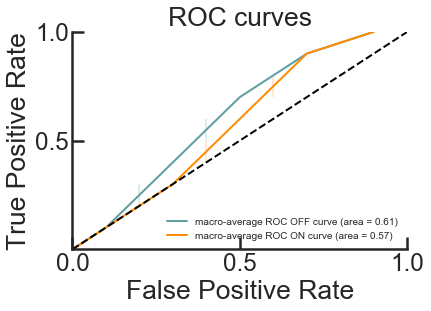

In [69]:
sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF_p, color='cadetblue', 
             linestyle='--', linewidth=2, ci=69,
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_off_all)))



sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON_p, color='darkorange', 
             linestyle='--', linewidth=2, ci=69,
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.nanmean(roc_mean_on_all)))


plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1.])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

### paired t-test for AUC

In [70]:
scipy.stats.ttest_rel(np.array(roc_mean_on_all)[~np.isnan(roc_mean_on_all)], np.array(roc_mean_off_all)[~np.isnan(roc_mean_on_all)])

Ttest_relResult(statistic=-4.372100862019711, pvalue=1.9018843532824774e-05)

# Albert's code

## First using raw spike counts for ROC curve

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

np.warnings.filterwarnings('ignore')

auc_off = np.zeros(number_neurons)
auc_on = np.zeros(number_neurons)

tprs_on = []
tprs_off = []
base_fpr = np.linspace(0, 1, 101)


for Neuron in range(number_neurons):
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    X =np.reshape(nx_x, (len(nx_x),1))
    
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        fpr, tpr, _ = roc_curve(y, nx_x) #HERE: compute ROC with raw spike counts nx_x
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        mean_tprs = tpr
    tprs_off.append(mean_tprs)

    auc_off[Neuron] = auc(base_fpr, mean_tprs)

    ## each column is a neuron
    nx_rates = rate_d1_on[:,Neuron]
    nx_positions = positions_stim_on[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    X =np.reshape(nx_x, (len(nx_x),1))
    
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        fpr, tpr, _ = roc_curve(y, nx_x)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        mean_tprs = tpr
    tprs_on.append(mean_tprs)

    auc_on[Neuron] = auc(base_fpr, mean_tprs)





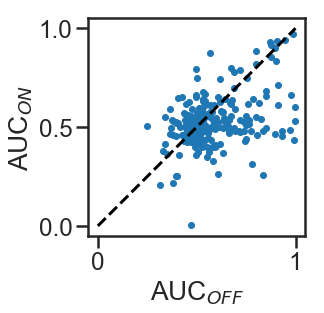

In [6]:
plt.plot(auc_off, auc_on, '.')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('AUC$_{OFF}$')
plt.ylabel('AUC$_{ON}$')
plt.axis('scaled');

No handles with labels found to put in legend.


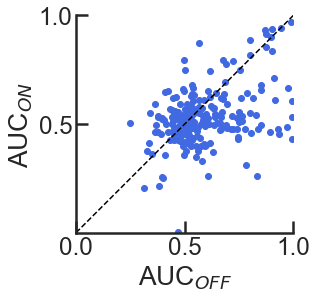

In [27]:
plt.plot(auc_off, auc_on, '.', color='royalblue', markersize=12)
plt.xlabel('AUC$_{OFF}$')
plt.ylabel('AUC$_{ON}$')
plt.axis('scaled');

plt.plot([0, 1], [0, 1], color='k', lw=1.5, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1.])
plt.yticks([0.5, 1])
plt.title('')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=14, frameon=False)
plt.show()

In [7]:
import scipy
#np.sum(np.isnan(auc_on))
ind = np.isnan(auc_on)
scipy.stats.ttest_rel(auc_off[~ind], auc_on[~ind])

Ttest_relResult(statistic=5.129432844338237, pvalue=6.39082064663582e-07)

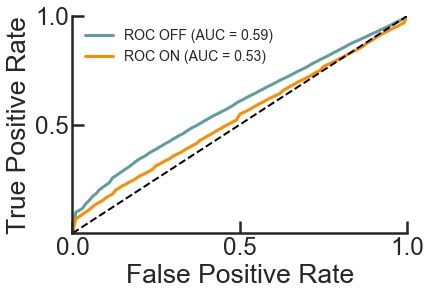

In [14]:
tprs_off = np.array(tprs_off)
tprs_on = np.array(tprs_on)
mean_tprs_off = np.nanmean(tprs_off, axis=0)
mean_tprs_on = np.nanmean(tprs_on, axis=0)
std_off = np.nanstd(tprs_off, axis=0)
std_on = np.nanstd(tprs_on, axis=0)

tprs_upper_off = np.minimum(mean_tprs_off + std_off, 1)
tprs_lower_off = mean_tprs_off - std_off
tprs_upper_on = np.minimum(mean_tprs_on + std_on, 1)
tprs_lower_on = mean_tprs_on - std_on

plt.plot(base_fpr, mean_tprs_off, 'cadetblue', label='ROC OFF (AUC = {0:0.2f})'''.format(np.mean(auc_off[~ind])))

plt.plot(base_fpr, mean_tprs_on, 'darkorange', label='ROC ON (AUC = {0:0.2f})'''.format(np.mean(auc_on[~ind])))

#plt.fill_between(base_fpr, tprs_lower_off, tprs_upper_off, color='grey', alpha=0.3)
#plt.fill_between(base_fpr, tprs_lower_on, tprs_upper_on, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1.])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=14, frameon=False)
plt.show()



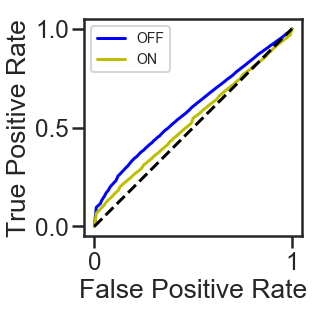

In [8]:
tprs_off = np.array(tprs_off)
tprs_on = np.array(tprs_on)
mean_tprs_off = np.nanmean(tprs_off, axis=0)
mean_tprs_on = np.nanmean(tprs_on, axis=0)
std_off = np.nanstd(tprs_off, axis=0)
std_on = np.nanstd(tprs_on, axis=0)

tprs_upper_off = np.minimum(mean_tprs_off + std_off, 1)
tprs_lower_off = mean_tprs_off - std_off
tprs_upper_on = np.minimum(mean_tprs_on + std_on, 1)
tprs_lower_on = mean_tprs_on - std_on

plt.plot(base_fpr, mean_tprs_off, 'b', label='OFF')
plt.plot(base_fpr, mean_tprs_on, 'y', label='ON')
#plt.fill_between(base_fpr, tprs_lower_off, tprs_upper_off, color='grey', alpha=0.3)
#plt.fill_between(base_fpr, tprs_lower_on, tprs_upper_on, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis('scaled')
plt.legend(fontsize=14)




### Both graphs together: not very nice

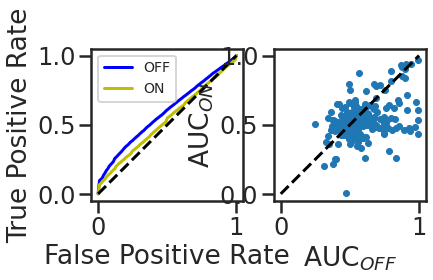

In [190]:
tprs_off = np.array(tprs_off)
tprs_on = np.array(tprs_on)
mean_tprs_off = np.nanmean(tprs_off, axis=0)
mean_tprs_on = np.nanmean(tprs_on, axis=0)
std_off = np.nanstd(tprs_off, axis=0)
std_on = np.nanstd(tprs_on, axis=0)

tprs_upper_off = np.minimum(mean_tprs_off + std_off, 1)
tprs_lower_off = mean_tprs_off - std_off
tprs_upper_on = np.minimum(mean_tprs_on + std_on, 1)
tprs_lower_on = mean_tprs_on - std_on

plt.subplot(1,2,1)

plt.plot(base_fpr, mean_tprs_off, 'b', label='OFF')
plt.plot(base_fpr, mean_tprs_on, 'y', label='ON')
#plt.fill_between(base_fpr, tprs_lower_off, tprs_upper_off, color='grey', alpha=0.3)
#plt.fill_between(base_fpr, tprs_lower_on, tprs_upper_on, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis('scaled')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.plot(auc_off, auc_on, '.')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('AUC$_{OFF}$')
plt.ylabel('AUC$_{ON}$')
plt.axis('scaled');


## This is the same but instead of raw spike counts, we use predictions from a logistic regression decoder in 3 folds

(-0.05, 1.05, -0.05, 1.05)

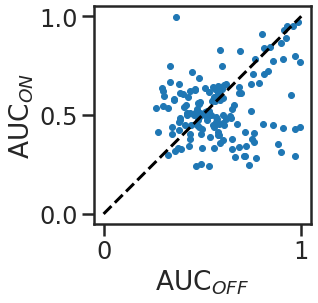

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

np.warnings.filterwarnings('ignore')

auc_off = np.zeros(number_neurons)
auc_on = np.zeros(number_neurons)

tprs_on = []
tprs_off = []
base_fpr = np.linspace(0, 1, 101)


for Neuron in range(number_neurons):
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[np.logical_and(np.isfinite(nx_positions),nx_positions>0)]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    X =np.reshape(nx_x, (len(nx_x),1))
    
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        kf = KFold(n_splits=3)

        tprsi = []

        for i, (train, test) in enumerate(kf.split(X,y, groups=y)):
            model = LogisticRegression(solver='lbfgs').fit(X[train], y[train])
            y_score = model.predict_proba(X[test])
            fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprsi.append(tpr)

        tprsi = np.array(tprsi)
        mean_tprs = tprsi.mean(axis=0)
    tprs_off.append(mean_tprs)

    auc_off[Neuron] = auc(base_fpr, mean_tprs)

    ## each column is a neuron
    nx_rates = rate_d1_on[:,Neuron]
    nx_positions = positions_stim_on[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    X =np.reshape(nx_x, (len(nx_x),1))
    
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        kf = KFold(n_splits=3)

        tprsi = []

        for i, (train, test) in enumerate(kf.split(X,y, groups=y)):
            model = LogisticRegression(solver='lbfgs').fit(X[train], y[train])
            y_score = model.predict_proba(X[test])
            fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprsi.append(tpr)

        tprsi = np.array(tprsi)
        mean_tprs = tprsi.mean(axis=0)
    tprs_on.append(mean_tprs)

    auc_on[Neuron] = auc(base_fpr, mean_tprs)

plt.plot(auc_off, auc_on, '.')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('AUC$_{OFF}$')
plt.ylabel('AUC$_{ON}$')
plt.axis('scaled')



In [161]:
import scipy
#np.sum(np.isnan(auc_on))
ind = np.isnan(auc_on)
scipy.stats.ttest_rel(auc_off[~ind], auc_on[~ind])

Ttest_relResult(statistic=2.8725477833139643, pvalue=0.004650417455389182)

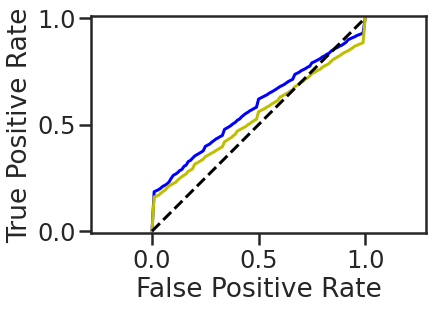

In [162]:
tprs_off = np.array(tprs_off)
tprs_on = np.array(tprs_on)
mean_tprs_off = np.nanmean(tprs_off, axis=0)
mean_tprs_on = np.nanmean(tprs_on, axis=0)
std_off = np.nanstd(tprs_off, axis=0)
std_on = np.nanstd(tprs_on, axis=0)

tprs_upper_off = np.minimum(mean_tprs_off + std_off, 1)
tprs_lower_off = mean_tprs_off - std_off
tprs_upper_on = np.minimum(mean_tprs_on + std_on, 1)
tprs_lower_on = mean_tprs_on - std_on


plt.plot(base_fpr, mean_tprs_off, 'b')
plt.plot(base_fpr, mean_tprs_on, 'y')
#plt.fill_between(base_fpr, tprs_lower_off, tprs_upper_off, color='grey', alpha=0.3)
#plt.fill_between(base_fpr, tprs_lower_on, tprs_upper_on, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

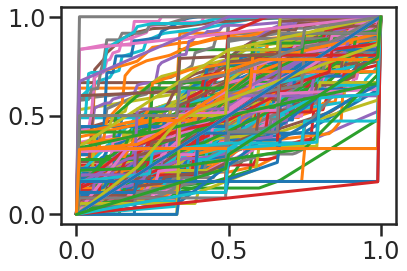

In [114]:
plt.plot(base_fpr, tprs_on.T);